A indexação foi feita utilizando-se o py4dstem nos notebooks
/home/ABTLUS/rodrigo.souza/4DSTEM/notebooks/hrtem/basics_3_Calibration.ipynb
/home/ABTLUS/rodrigo.souza/4DSTEM/notebooks/hrtem/basics_4_Maps.ipynb

gerando os .npy braggpeaks, orientation_map e orientation_map_corr.

Será necessário posteriormente fazer a migração para trabalhar com dados não 4D.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import pyxem as pxm
import os

In [25]:
PATH = '/home/ABTLUS/victor.secco/data_processing/TEM_data/Pt2HgSe3_exfoliado_lavado'
names = [x for x in os.listdir(PATH)]
images = []

for name in names:
    s = hs.load(os.path.join(PATH,name))
    images.append(np.array(s))



In [27]:
images.pop(9)
names

['Pt2HgSe3_exfoliado_lavado5.dm4',
 'Pt2HgSe3_exfoliado_lavado6.dm4',
 'Pt2HgSe3_exfoliado_lavado10.dm4',
 'Pt2HgSe3_exfoliado_lavado1.dm4',
 'Pt2HgSe3_exfoliado_lavado8.dm4',
 'Pt2HgSe3_exfoliado_lavado3.dm4',
 'Pt2HgSe3_exfoliado_lavado9.dm4',
 'Pt2HgSe3_exfoliado_lavado12.dm4',
 'Pt2HgSe3_exfoliado_lavado13.dm4',
 'Pt2HgSe3_exfoliado_lavado7.dm4',
 'Pt2HgSe3_exfoliado_lavado11.dm4',
 'Pt2HgSe3_exfoliado_lavado4.dm4']

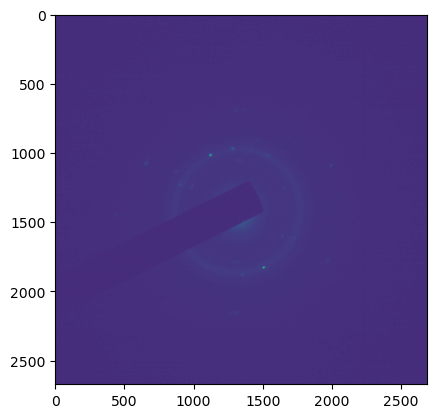

In [29]:
plt.imshow(images[10])

/tmp/ipykernel_186337/398430509.py:6: RuntimeWarning: invalid value encountered in log
  ax.imshow(np.log(images[i]), cmap = 'gray')


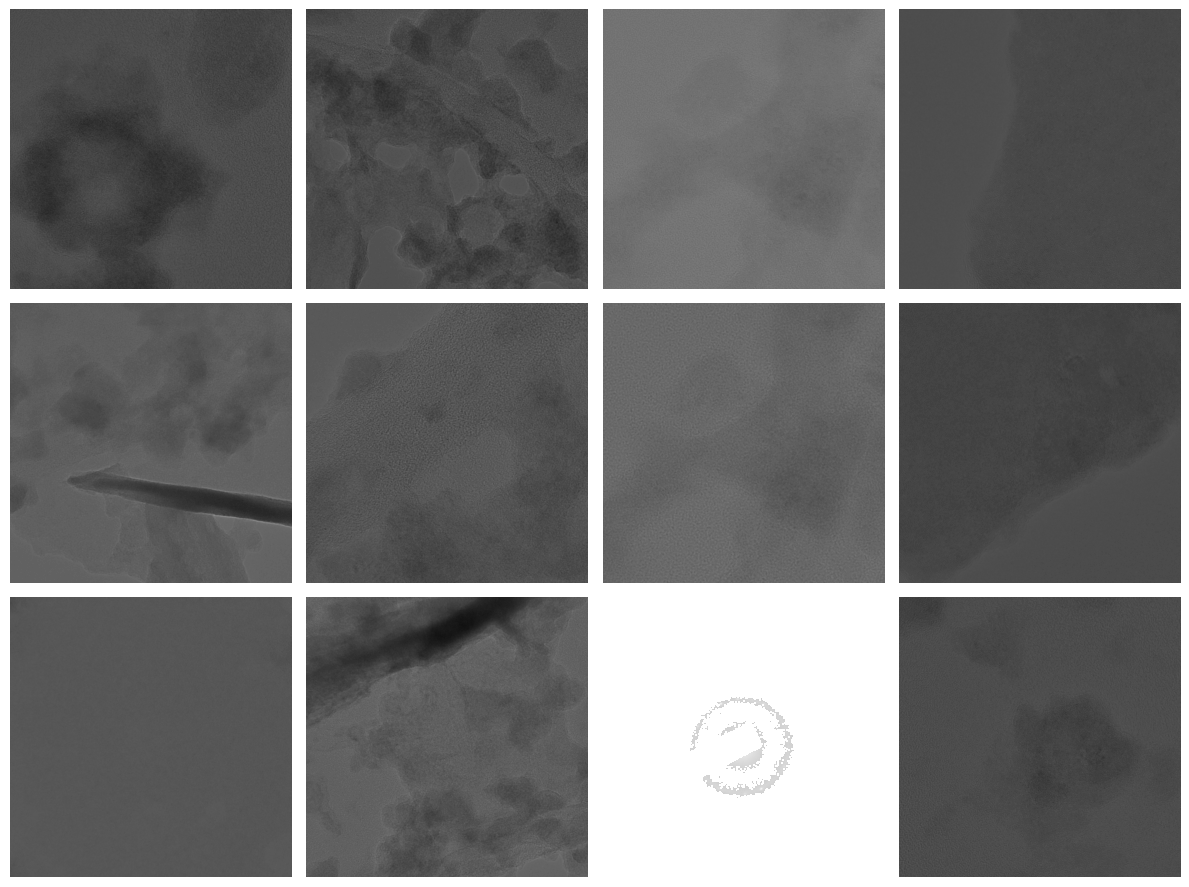

In [28]:
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

# Iterate over the images and corresponding subplot axes
for i, ax in enumerate(axes.flatten()):
    if i < len(images):  # Check if there is an image for this subplot
        ax.imshow(np.log(images[i]), cmap = 'gray')
        ax.axis('off')  # Hide the axis for better visualization
    else:
        ax.axis('off')  # If no image, just turn off the axis

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Peak finding (blob_dog)
https://pyxem.readthedocs.io/en/stable/tutorials/pyxem-demos/01%20GaAs%20Nanowire%20-%20Data%20Inspection%20-%20Preprocessing%20-%20Unsupervised%20Machine%20Learning.html

## Tuning hyperparameters

In [31]:
from skimage.feature import blob_dog

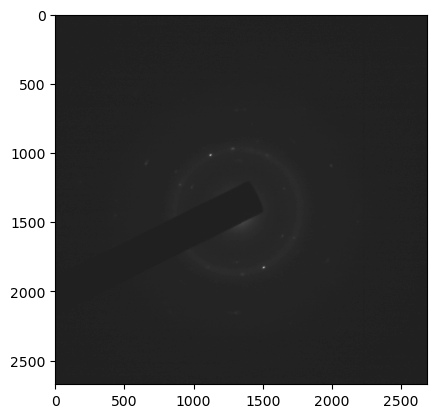

In [38]:
min_sigma = 10
sigma_ratio = 7
threshold = 50
peaks = blob_dog(images[10],
                     min_sigma = min_sigma,
                     sigma_ratio = sigma_ratio,
                     threshold = threshold,
                     exclude_border=10
                     )

plt.imshow(images[10], cmap = 'gray')


/tmp/ipykernel_186337/43288892.py:4: RuntimeWarning: invalid value encountered in log
  ax.imshow(np.log(images[10]))


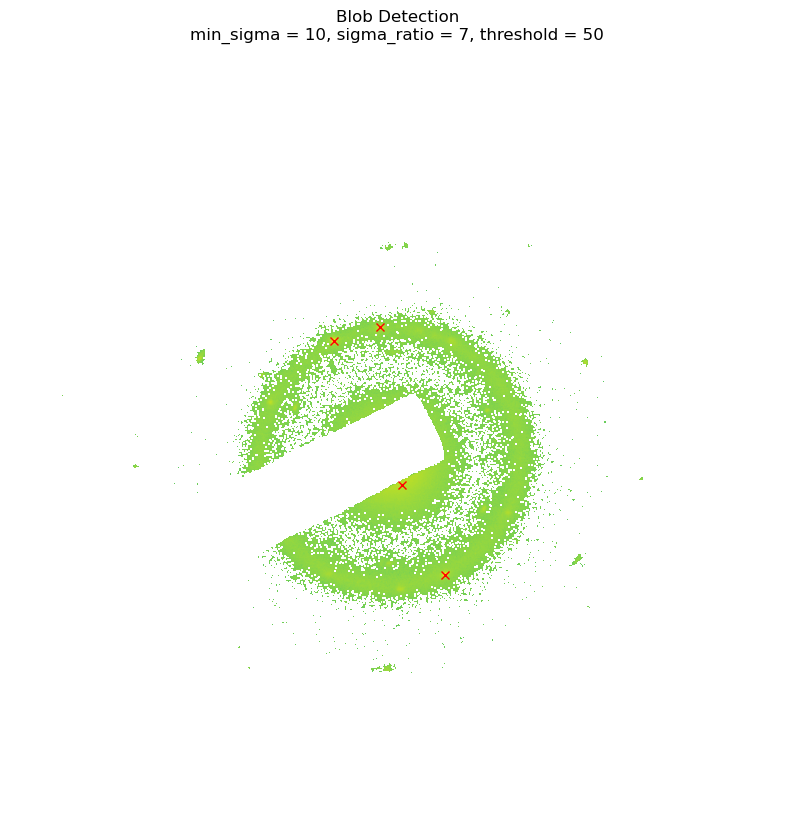

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the logarithm of the image
ax.imshow(np.log(images[10]))

# Overlay the detected blobs as red crosses
ax.plot(peaks[:, 1], peaks[:, 0], 'rx')

# Set the title with the blob detection parameters
ax.set_title(f'Blob Detection\nmin_sigma = {min_sigma}, sigma_ratio = {sigma_ratio}, threshold = {threshold}')

# Hide axis ticks and labels for better visualization
ax.axis('off')

# Show the plot
plt.show()

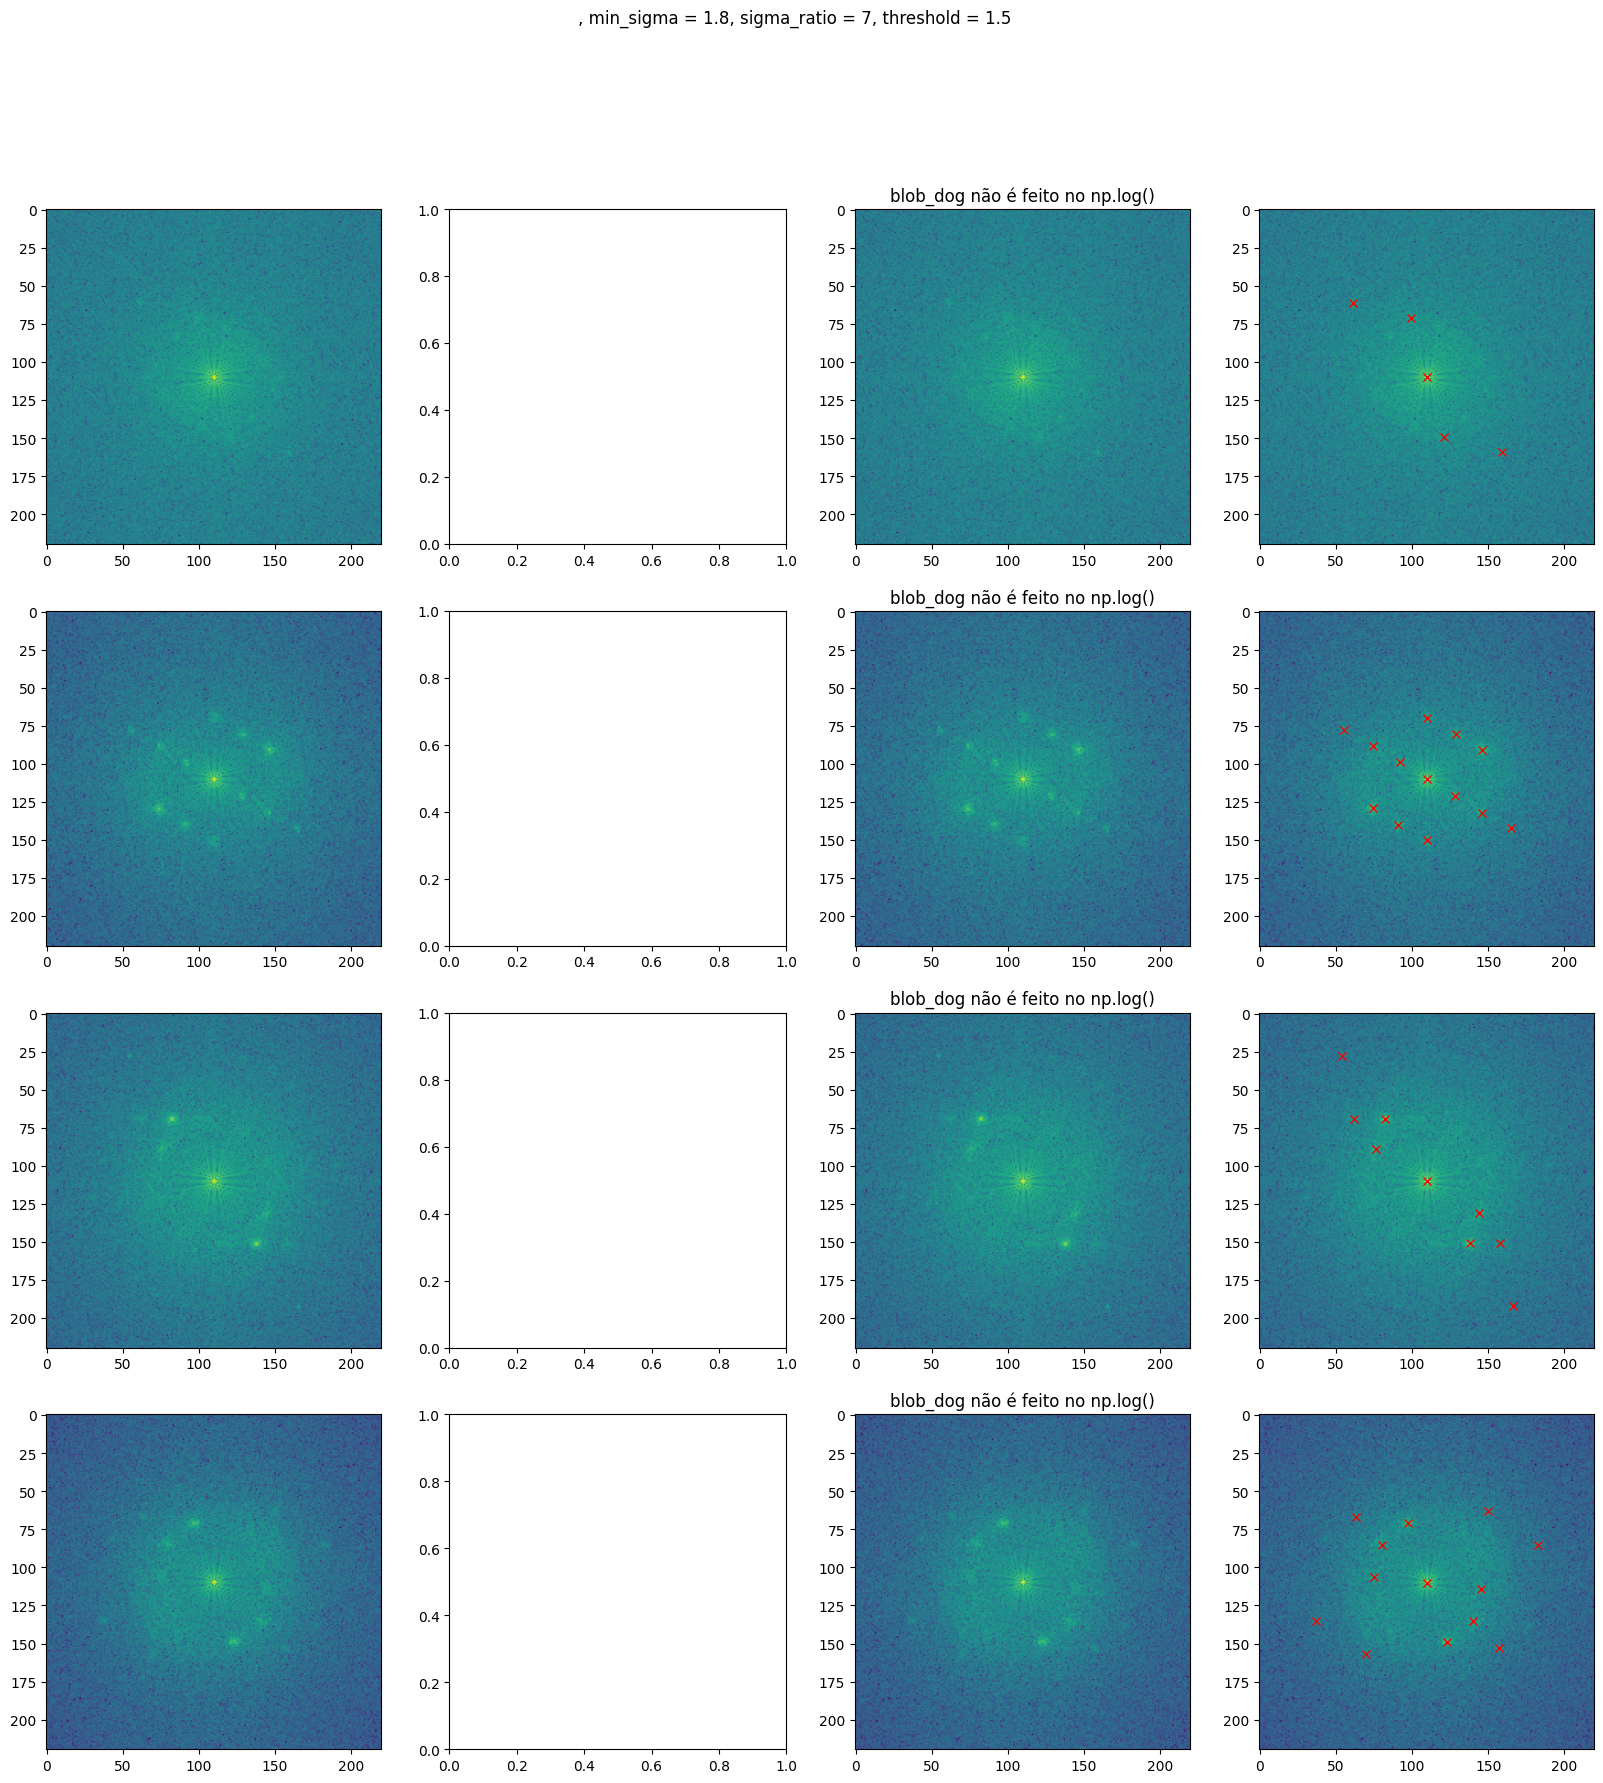

In [60]:
# Dos testes feitos, parece que é possível seguir sem precisar do PCA

cropsoi = [1000, 1001, 1005, 1013]
# cropsoi = [19, 1, 17]
# cropsoi=range(20)
fig, ax = plt.subplots(len(cropsoi),4, figsize=(20,5*len(cropsoi)))
row=0
for crop in cropsoi:
    ex = s.data[crop]
    # ex = (sc.data[crop])
    # ex = filters.gaussian(ex, sigma=3)

    min_sigma = 1.8
    sigma_ratio = 7
    threshold = 1.5
    peaks = blob_dog(ex,
                     min_sigma = min_sigma,
                     sigma_ratio = sigma_ratio,
                     threshold = threshold,
                     exclude_border=10
                     )
    ax[row,0].imshow(np.log(s.data[crop]))
    # tdata1 = np.fft.ifft2(np.fft.ifftshift(np.exp(np.log(s.data[crop]) + 1j * np.angle(fshifts[crop])))).real
    # ax[row,1].imshow(tdata1)
    ax[row,2].imshow(np.log(ex))
    ax[row,2].set_title('blob_dog não é feito no np.log()')
    ax[row,3].imshow(np.log(s.data[crop]))
    ax[row,3].plot(peaks[:,1], peaks[:,0], 'rx')
    fig.suptitle(
                # str(n) +
                  ', min_sigma = ' + str(min_sigma)
                  + ', sigma_ratio = ' + str(sigma_ratio)
                  + ', threshold = ' + str(threshold)
                 )
    row+=1

In [28]:
s.data[0][110,110]

17493.53826148792

In [58]:
# Performing for all ~8 min
peaks = []
for i in range(len(s.data)):
    fft = s.data[i]
    min_sigma = 1.8
    sigma_ratio = 7
    threshold = 1.5
    peaks_i = blob_dog(fft,
                     min_sigma = min_sigma,
                     sigma_ratio = sigma_ratio,
                     threshold = threshold,
                     exclude_border=10
                     )
    peaks_i = np.delete(peaks_i, 2, axis = 1)

    peaks_i = peaks_i.tolist()
    for j in range(len(peaks_i)):
        # peak = peaks_i[j]
        # print('peak =', peak)
        intensity = s.data[i][int(peaks_i[j][1]), int(peaks_i[j][0])]
        peaks_i[j].append(intensity)
    peaks_i = np.array(peaks_i)
    peaks.append(peaks_i)
peaks = np.array(peaks, dtype=object) # jagged array (nao uniforme)

In [59]:
np.save('/home/ABTLUS/rodrigo.souza/HRTEM/notebooks/peaks', peaks)

## Loading peaks aquired from blob_dog

In [10]:
peaks = np.load('/home/ABTLUS/rodrigo.souza/HRTEM/notebooks/peaks.npy', allow_pickle=True)

Text(0.5, 0.98, 'ffts peaks histogram')

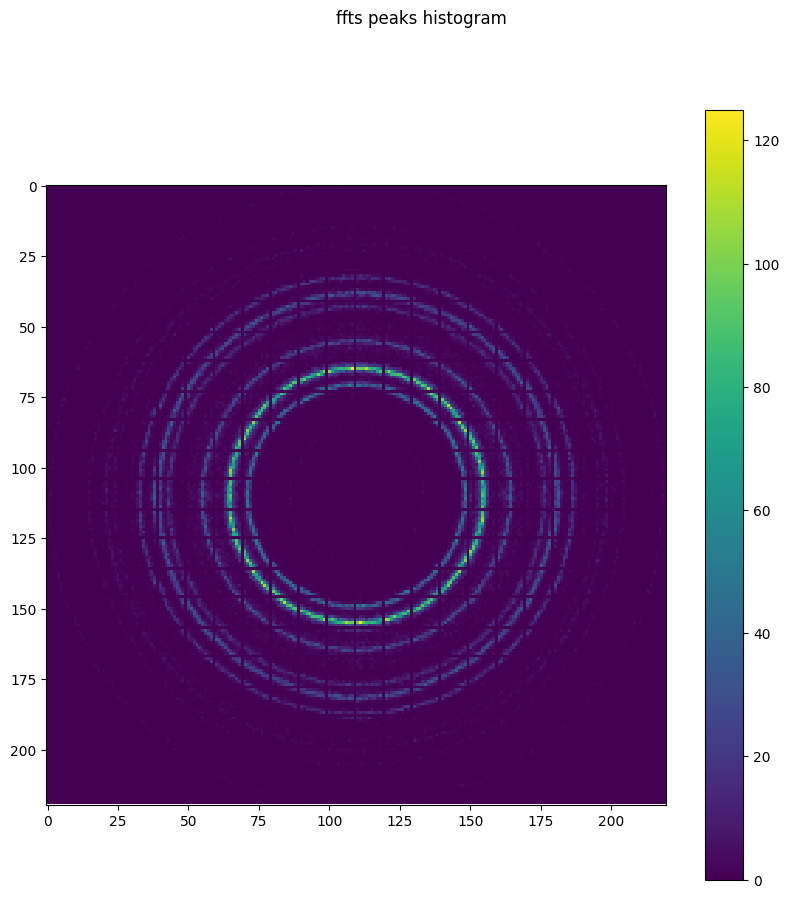

In [6]:
# Plotting histogram
x=[]
y=[]
for peaks_i in peaks:
    for i, (xi,yi) in enumerate(peaks_i):
        if i != 0:
            x.append(xi)
            y.append(yi)
x = np.array(x)
y = np.array(y)        

hist, xedges, yedges = np.histogram2d(x, y, bins=[220,220])
# hist = np.clip(hist, 0, 1000)
fig,ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(hist, interpolation='nearest')
fig.colorbar(cax)
fig.suptitle('ffts peaks histogram')


Esse quadriculado deve ser resultado do blob size (sigma_min)

### Hyperspy s cluster?

In [9]:
from sklearn.cluster import DBSCAN, KMeans

In [14]:
s = peaks.as_signal()

AttributeError: 'numpy.ndarray' object has no attribute 'as_signal'

In [12]:
peaks.cluster_analysis(cluster_source="signal", algorithm=KMeans(n_clusters=3, n_init=8))

AttributeError: 'numpy.ndarray' object has no attribute 'cluster_analysis'

# Indexing

## pyxem, method 1
https://pyxem.readthedocs.io/en/stable/tutorials/pyxem-demos/02%20GaAs%20Nanowire%20-%20Phase%20Mapping%20-%20Orientation%20Mapping.html# 

In [3]:
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

from diffsims.generators.zap_map_generator import get_rotation_from_z_to_direction
from diffsims.generators.rotation_list_generators import get_grid_around_beam_direction

from pyxem.generators.indexation_generator import AcceleratedIndexationGenerator
from pyxem.utils.indexation_utils import results_dict_to_crystal_map
import diffpy.structure

In [5]:
diffraction_calibration = 1/0.237
s.data *= 1 / s.data.max()
s.set_signal_type('electron_diffraction')
s.metadata

├── General
│   ├── FileIO
│   │   ├── 0
│   │   │   ├── hyperspy_version = 2.1.0
│   │   │   ├── io_plugin = rsciio.hspy
│   │   │   ├── operation = save
│   │   │   └── timestamp = 2024-05-23T11:02:17.041152-03:00
│   │   └── 1
│   │       ├── hyperspy_version = 2.1.0
│   │       ├── io_plugin = rsciio.hspy
│   │       ├── operation = load
│   │       └── timestamp = 2024-05-27T14:08:48.916104-03:00
│   └── title = 
└── Signal
    └── signal_type = electron_diffraction

In [6]:
structure = diffpy.structure.loadStructure('/home/ABTLUS/rodrigo.souza/HRTEM/datasets/Fe3O4_15mar/metadata/Magnetite.cif')
rot_list_cubic = np.array([[0.0, 90.0, 225.0],])
struc_lib = StructureLibrary(['ZB'],
                             [structure],
                             [rot_list_cubic])
diff_gen = DiffractionGenerator(accelerating_voltage=300)
lib_gen = DiffractionLibraryGenerator(diff_gen)

In [7]:
target_pattern_dimension_pixels = s.axes_manager.signal_shape[0]
half_size = target_pattern_dimension_pixels // 2
reciprocal_radius = diffraction_calibration*(half_size - 1)

diff_lib = lib_gen.get_diffraction_library(struc_lib,
                                           calibration=diffraction_calibration,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=(half_size, half_size),
                                           max_excitation_error=1/10,
                                           with_direct_beam=False)

  0%|          | 0/1 [00:00<?, ?it/s]

: 

## pyxem, method 2 (which is almost the same, but more customizable)
https://pyxem.readthedocs.io/en/stable/tutorials/pyxem-demos/11%20Accelerated%20orientation%20mapping%20with%20template%20matching.html

In [3]:
s

<Signal2D, title: , dimensions: (13248|220, 220)>

In [14]:
diffraction_calibration = 1/0.237
s.set_diffraction_calibration(diffraction_calibration)

AttributeError: 'Signal2D' object has no attribute 'set_diffraction_calibration'

Number of patterns:  496


(-0.1, 0.5)

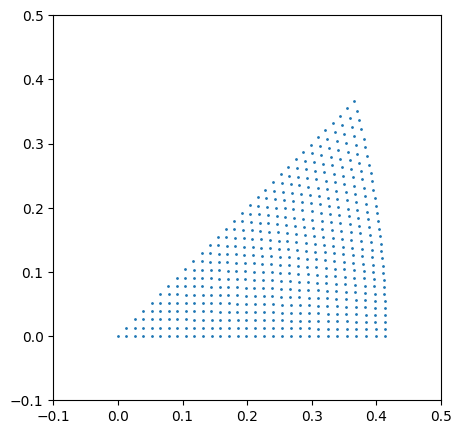

In [11]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
resolution = 1.5 # maximum angle in degrees between nearest templates. Pretty rough grid for speed.
grid_cub = get_beam_directions_grid("cubic", resolution, mesh="spherified_cube_edge")
print("Number of patterns: ", grid_cub.shape[0])
# this cell serves to visualize the grid of orientations in stereographic projection

# a helper function for turning the euler angle grid to a grid of points in the stereographic projection
def grid_to_xy(grid):
    from orix.quaternion.rotation import Rotation
    from orix.vector.vector3d import Vector3d
    from orix.projections import StereographicProjection
    s = StereographicProjection(pole=-1)
    rotations_regular =  Rotation.from_euler(np.deg2rad(grid))
    rot_reg_test = rotations_regular*Vector3d.zvector()
    x, y = s.vector2xy(rot_reg_test)
    return x, y

fig, ax1 = plt.subplots(1, figsize=(5, 5))
ax1.scatter(*grid_to_xy(grid_cub), s = 1)
ax1.set_xlim(-0.1, 0.5)
ax1.set_ylim(-0.1, 0.5)

In [12]:
import diffpy
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

In [15]:
# Parameters necessary for simulating a template library

# half size of the images
half_shape = (s.data.shape[-2]//2, s.data.shape[-1]//2)
# maximum radius in reciprocal space to calculate spot intensities for
reciprocal_radius = np.sqrt(half_shape[0]**2 + half_shape[1]**2)*diffraction_calibration

In [21]:
# importing the structure
structure_matrix = diffpy.structure.loadStructure("/home/ABTLUS/rodrigo.souza/HRTEM/datasets/Fe3O4_15mar/metadata/Magnetite.cif")

In [23]:
# "The microscope = the parameters that determine how the templates are calculated"
diff_gen = DiffractionGenerator(accelerating_voltage=300,
                                precession_angle=0,
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity=0.1,
                                )
lib_gen = DiffractionLibraryGenerator(diff_gen)

In [25]:
# Generating a library
# "Library of structures and orientations"
library_phases_fe = StructureLibrary(["fe"], [structure_matrix], [grid_cub])
# Calculate the actual library

diff_lib_fe = lib_gen.get_diffraction_library(library_phases_fe,
                                           calibration=diffraction_calibration,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=half_shape,
                                           with_direct_beam=False,
                                           max_excitation_error=0.07)

  0%|          | 0/496 [00:00<?, ?it/s]

: 

# Clustering

## pyxem, method 1
https://pyxem.readthedocs.io/en/stable/examples/vectors/clustering_vectors.html#sphx-glr-examples-vectors-clustering-vectors-py

### Exemplo do link

In [42]:
from scipy.ndimage import gaussian_filter
# Getting the vectors for some dataset
sex = pxm.data.mgo_nanocrystals()
sex.data[sex.data < 120] = 1
sex.filter(gaussian_filter, sigma=(0.5, 0.5, 0, 0), inplace=True)  # only in real space
sex.template_match_disk(disk_r=3, subtract_min=False, inplace=True)
vectors = sex.get_diffraction_vectors(threshold_abs=0.5, min_distance=3)

[########################################] | 100% Completed | 15.07 s
[########################################] | 100% Completed | 10.96 s
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 101.26 ms


In [ ]:
vectors

In [43]:
sex

<ElectronDiffraction2D, title: MgO Nano-Crystals, dimensions: (105, 105|144, 144)>

In [33]:
print(vectors)
print(vectors.data.shape)
flat_vectors = vectors.flatten_diffraction_vectors()
print(flat_vectors)
print(flat_vectors.data.shape)

<DiffractionVectors, title: MgO Nano-Crystals, dimensions: (105, 105|ragged)>
(105, 105)
<DiffractionVectors2D, title: , dimensions: (|5, 52625)>
(52625, 5)


### meu

In [95]:
s_pxm = pxm.signals.ElectronDiffraction2D(s)
s_pxm.template_match_disk(disk_r = 3, subtract_min = False, inplace=True)
vectors = s_pxm.get_diffraction_vectors(threshold_abs= 0.5, min_distance=3)

[########################################] | 100% Completed | 11.15 s
[########################################] | 100% Completed | 38.94 s
[########################################] | 100% Completed | 39.02 s
[########################################] | 100% Completed | 101.90 ms
[########################################] | 100% Completed | 16.63 s
[########################################] | 100% Completed | 16.70 s
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:5320)


[########################################] | 100% Completed | 101.91 ms
[########################################] | 100% Completed | 201.92 ms


In [102]:
print(vectors)

<DiffractionVectors, title: , dimensions: (13248|ragged)>


/tmp/ipykernel_2947/1041313453.py:3: RuntimeWarning: invalid value encountered in log
  ax[0].imshow(np.log(s.data[1]))
/tmp/ipykernel_2947/1041313453.py:4: RuntimeWarning: invalid value encountered in log
  ax[1].imshow(np.log(s.data[1]))


Text(0.5, 1.0, 'pxm.template_match_disk')

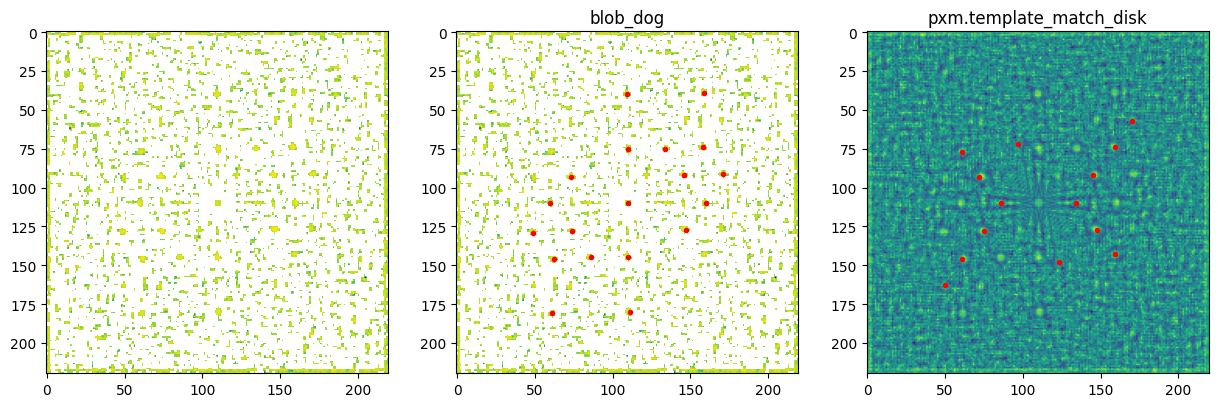

In [96]:
# Comparing both methods
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(np.log(s.data[1]))
ax[1].imshow(np.log(s.data[1]))
ax[1].scatter(peaks[1][:,1], peaks[1][:,0], color='r', marker='.')
ax[1].set_title('blob_dog')
ax[2].imshow(s_pxm.data[1])
ax[2].scatter(vectors.data[1][:,1], vectors.data[1][:,0], color='r', marker='.')
ax[2].set_title('pxm.template_match_disk')


In [97]:
from sklearn.cluster import DBSCAN

In [106]:
flat_vectors = vectors.flatten_diffraction_vectors()
scan = DBSCAN(eps=20, min_samples = 2)
print(flat_vectors)
scan

<DiffractionVectors2D, title: , dimensions: (|4, 90587)>


DBSCAN(eps=20, min_samples=2)

In [107]:
clustered = flat_vectors.cluster(scan,
                                # column_scale_factors=[10, 10, 0.05, 0.05],
                                # columns=[0, 1, 2, 3],
                                # min_vectors=40,
                                )

[                                        ] | 0% Completed | 606.71 ms
[                                        ] | 0% Completed | 708.22 ms
[                                        ] | 0% Completed | 808.82 ms
[                                        ] | 0% Completed | 908.33 ms
[                                        ] | 0% Completed | 909.31 ms


ValueError: could not broadcast input array from shape (90153,5) into shape (90587,5)

Estou tentando um dos vários métodos de indexing e cluster. Não tenho ctz qual fazer primeiro, parece que dá par afazer cluster sem precisar indexar